In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
import scipy.signal

In [2]:
data_matrix = np.load('extract/nid/extact_matrix.npy', allow_pickle=True)

In [3]:

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


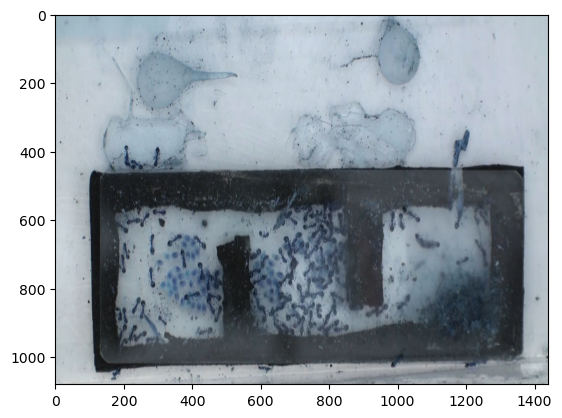

In [7]:
plt.imshow(data_matrix[0])

In [4]:
import cv2

In [9]:
data_matrix_gray=[0,0]
data_matrix_gray[0]=cv2.cvtColor(data_matrix[0], cv2.COLOR_BGR2GRAY)
data_matrix_gray[1]=cv2.cvtColor(data_matrix[1], cv2.COLOR_BGR2GRAY)

Gaussien filter

## thresholding

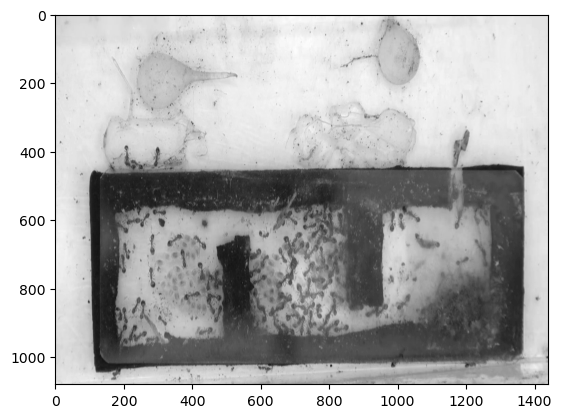

In [20]:
plt.imshow(data_matrix[0][:,:,2], cmap='gray')

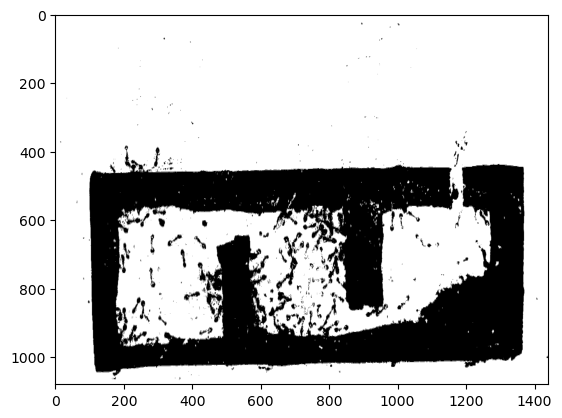

In [34]:
test=np.where(data_matrix[0][:,:,2]>100,255,0)
plt.imshow(test, cmap='gray')

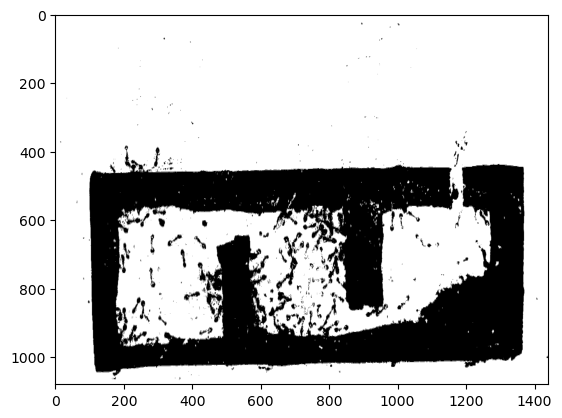

In [35]:
test1=np.where(data_matrix[1][:,:,2]>100,255,0)
plt.imshow(test, cmap='gray')

## substraction

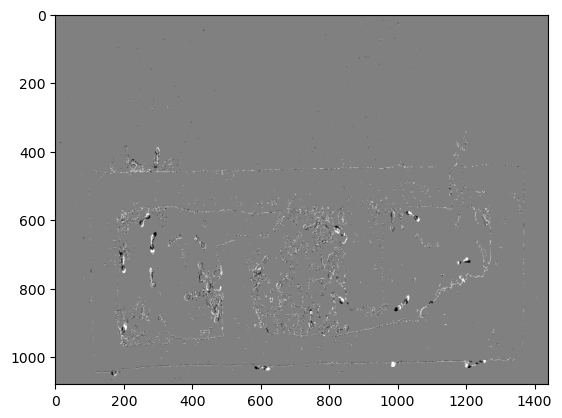

In [36]:
pos=np.where(test1-test>0,0,255)
neg=np.where(test1-test<0,0,255)
plt.imshow(test1-test, cmap='gray')

In [38]:
sub=test1-test

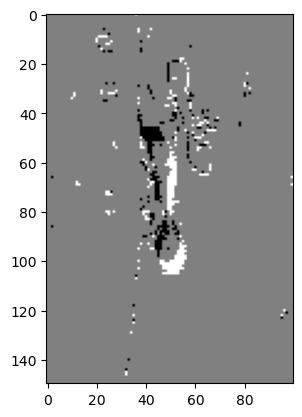

In [39]:
plt.imshow(sub[650:800,150:250],cmap='gray')

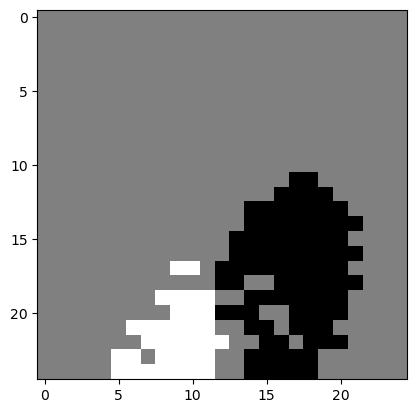

In [40]:
plt.imshow(sub[625:650,275:300],cmap='gray')

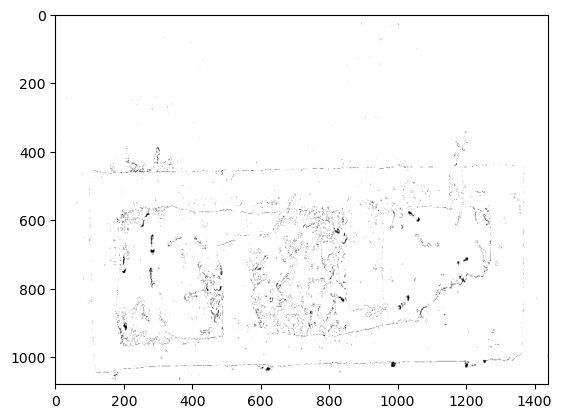

In [41]:
plt.imshow(pos, cmap='gray')

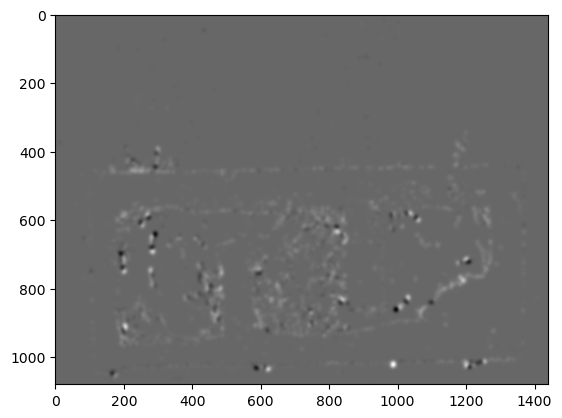

In [57]:
smooth_sub=convolve2d(sub,gaussianKernel(5),mode='same')
plt.imshow(smooth_sub, cmap='gray')

## Find head and tail and move

In [44]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    # compute the derivatives
    Ix = convolve2d(image, np.array([[-1, 0, 1]]), mode='same')
    Iy = convolve2d(image, np.array([[-1, 0, 1]]).T, mode='same')
    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy
    # compute the gaussian kernel
    kern = gaussianKernel(scale)
    # compute the sum of the squares of the derivatives
    Sxx = convolve2d(Ixx, kern, mode='same')
    Syy = convolve2d(Iyy, kern, mode='same')
    Sxy = convolve2d(Ixy, kern, mode='same')
    # compute the R matrix
    R = (Sxx*Syy - Sxy**2) - kappa*(Sxx+Syy)**2
    return R

In [45]:
def rnms(image_harris,Rbin):
    """ Array[n, m] -> Array[n, m] 
    """
    # compute the size of the image
    n,m = image_harris.shape
    # create a new image
    image_rnms = np.zeros((n,m))
    # for each pixel
    for i in range(1,n-1):
        for j in range(1,m-1):
            # if the pixel is a local maximum,check if the pixel is the local maximum of its 8-neighborhood
            if Rbin[i,j] == 1 and np.max(image_harris[i-1:i+2, j-1:j+2]) == image_harris[i,j]:
                image_rnms[i,j] = 1
    return image_rnms

def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image, sigma, kappa)
    max,min=R.max(),R.min()
    Rnorm=(R-min)/(max-min)
    Rbin = thresholdR(Rnorm, thres)
    image_rnms = rnms(Rnorm, Rbin)
    return image_rnms

def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return(np.where(R>thres, 1, 0))

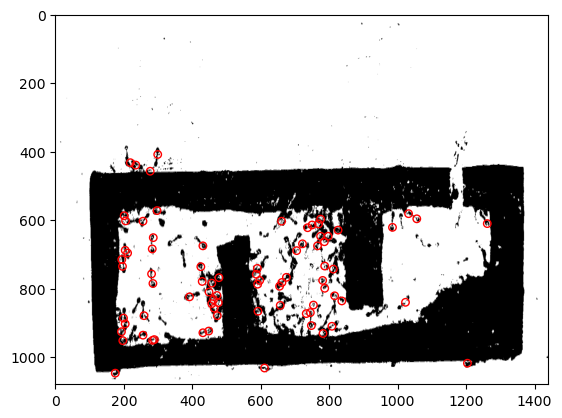

In [126]:
sigma=5
kappa=0.04
thres=0.3
image_rnms = cornerDetector(sub, sigma, kappa, thres)

n2=int(np.ceil(3*sigma))
x,y=np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
corners=np.argwhere(image_rnms==1)

plt.imshow(test,cmap='gray')
plt.scatter(corners[:,1],corners[:,0],s=2*n2-1,marker='o',edgecolors='r',facecolors='none')

plt.show()

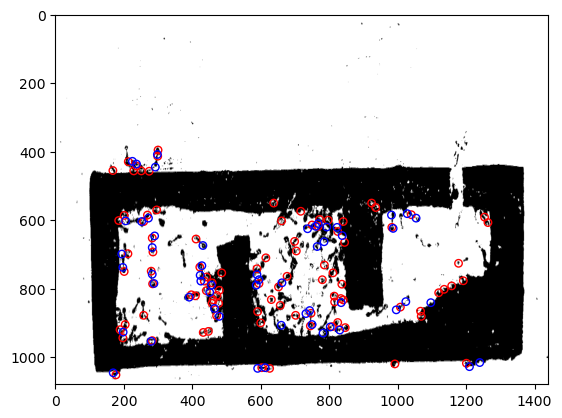

In [67]:
sigma=5
kappa=0.04
thres=0.3
image_rnms = cornerDetector(pos, sigma, kappa, thres)
image_rnms2 = cornerDetector(neg, sigma, kappa, thres)

n2=int(np.ceil(3*sigma))
x,y=np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
corners=np.argwhere(image_rnms==1)
corners2=np.argwhere(image_rnms2==1)
plt.imshow(test,cmap='gray')
plt.scatter(corners[:,1],corners[:,0],s=2*n2-1,marker='o',edgecolors='r',facecolors='none')
plt.scatter(corners2[:,1],corners2[:,0],s=2*n2-1,marker='o',edgecolors='b',facecolors='none')
plt.show()

In [68]:
n2

15

In [71]:
corners[0]

array([395, 300])

In [72]:
test[corners[0][0],corners[0][1]]

0

In [78]:
(corners[0]-corners[1] ==[0,0]).all()

False

In [94]:
body=[]
for pos1 in corners:
    for pos2 in corners:
        mean=np.mean([pos1,pos2],axis=0)
        if np.linalg.norm(pos1-pos2)<50 and ((pos1-pos2) != [0,0]).all:
            body.append([pos1,pos2])
body=np.array(body)
body

array([[[ 395,  300],
        [ 395,  300]],

       [[ 395,  300],
        [ 413,  299]],

       [[ 413,  299],
        [ 395,  300]],

       ...,

       [[1033,  626],
        [1031,  603]],

       [[1033,  626],
        [1033,  626]],

       [[1052,  177],
        [1052,  177]]])

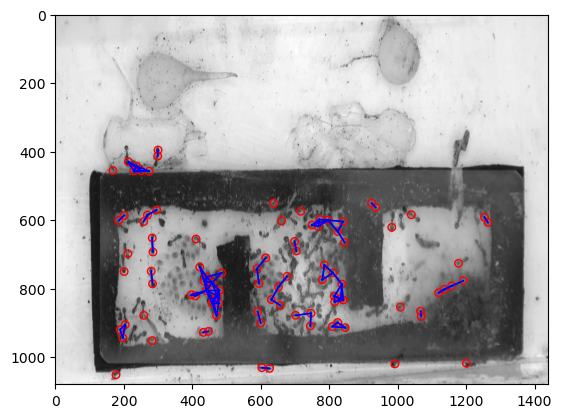

In [95]:
for line in body:
    plt.plot(line[:,1],line[:,0],c='b',linewidth=1)
plt.imshow(data_matrix_gray[0],cmap='gray')
plt.scatter(corners[:,1],corners[:,0],s=2*n2-1,marker='o',edgecolors='r',facecolors='none')
plt.show()

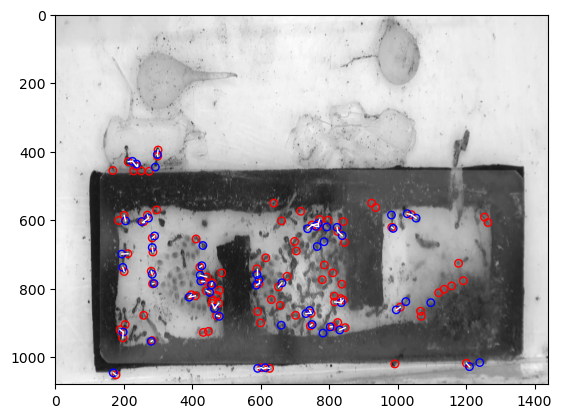

In [101]:
move=[]
for pos in corners:
    for neg in corners2:
        if np.linalg.norm(pos-neg)<20:
            move.append([pos,neg])
move=np.array(move)
for line in move:
    plt.plot(line[:,1],line[:,0],c='white',linewidth=1)
plt.imshow(data_matrix_gray[0],cmap='gray')
plt.scatter(corners[:,1],corners[:,0],s=2*n2-1,marker='o',edgecolors='r',facecolors='none')
plt.scatter(corners2[:,1],corners2[:,0],s=2*n2-1,marker='o',edgecolors='b',facecolors='none')
plt.show()

## entiere

In [102]:
data_matrix_en = np.load('extract/entiere/extact_matrix.npy', allow_pickle=True)

In [110]:
data_matrix_en_gray=[0,0]
data_matrix_en_gray[0]=cv2.cvtColor(data_matrix_en[0], cv2.COLOR_BGR2GRAY)
data_matrix_en_gray[1]=cv2.cvtColor(data_matrix_en[1], cv2.COLOR_BGR2GRAY)
test_en=np.where(data_matrix_en[0][:,:,2]>100,255,0)
test1_en=np.where(data_matrix_en[1][:,:,2]>100,255,0)


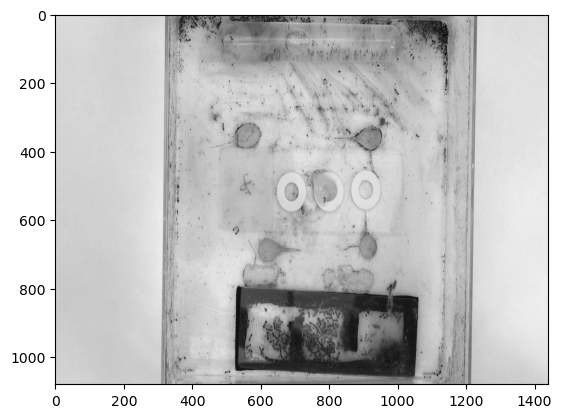

In [116]:
plt.imshow(data_matrix_en_gray[1],cmap='gray')

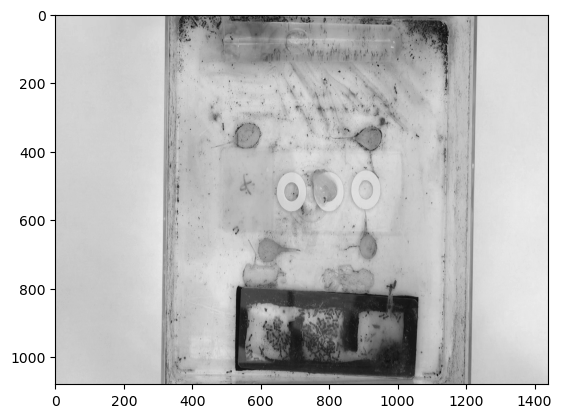

In [117]:
plt.imshow(data_matrix_en_gray[0],cmap='gray')

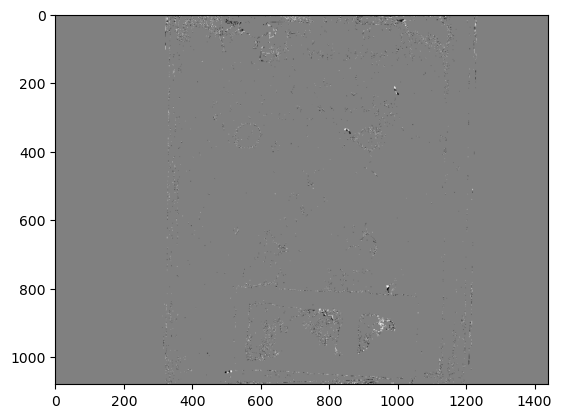

In [111]:
sub_en=test1_en-test_en
pos_en=np.where(sub_en>0,0,255)
neg_en=np.where(sub_en<0,0,255)

plt.imshow(sub_en, cmap='gray')

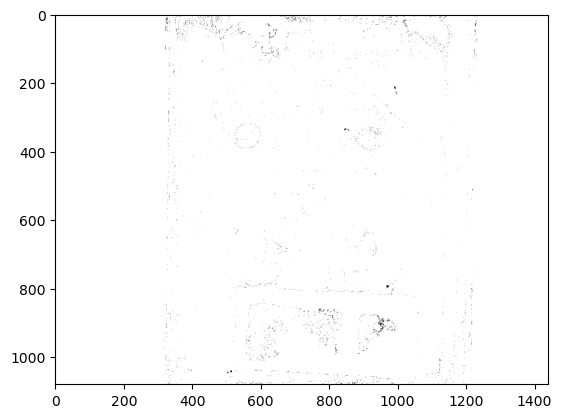

In [118]:
plt.imshow(pos_en, cmap='gray')

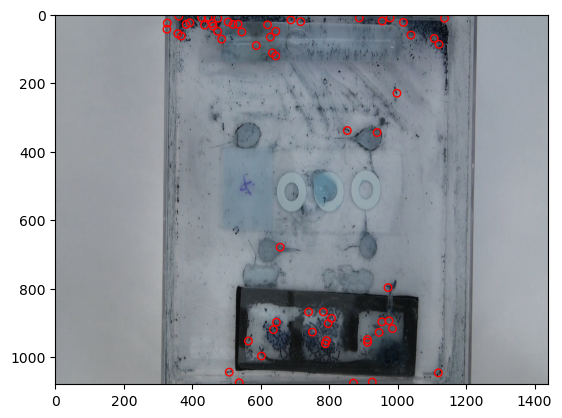

In [125]:
sigma=5
kappa=0.04
thres=0.2
image_rnms = cornerDetector(sub_en, sigma, kappa, thres)

n2=int(np.ceil(3*sigma))
x,y=np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
corners=np.argwhere(image_rnms==1)
plt.imshow(data_matrix_en[0],cmap='gray')
plt.scatter(corners[:,1],corners[:,0],s=2*n2-1,marker='o',edgecolors='r',facecolors='none')
plt.show()

## Find points

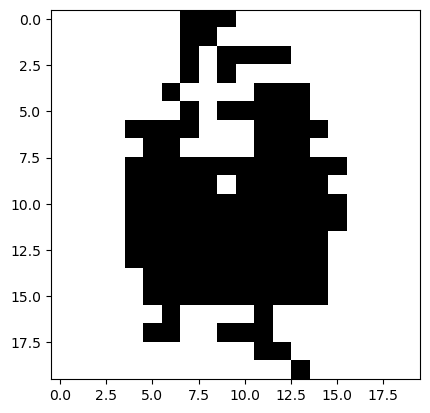

In [58]:
plt.imshow(test[680:700,275:295],cmap='gray')

In [43]:
np.mean(test[680:700,275:295])

170.2125

In [51]:
smooth_fourmis = convolve2d(test, gaussianKernel(2))

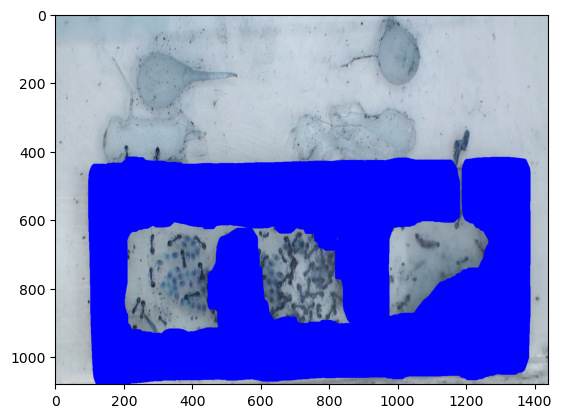

In [52]:
img_rgb = data_matrix[0].astype(np.uint8)
img_gray = smooth_fourmis.astype(np.uint8)
template = smooth_fourmis[625:700,275:300].astype(np.uint8)
w, h = template.shape[::-1]
res = cv2.matchTemplate(img_gray,template,cv2.TM_SQDIFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
plt.imshow(img_rgb)


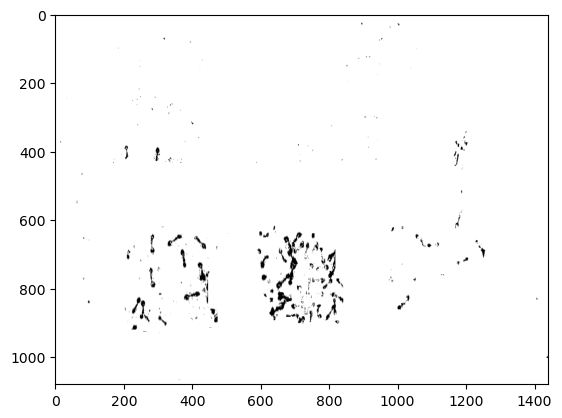

In [55]:
new=test.copy()
for i,j in zip(*loc[::-1]):
    new[j:j+h,i:i+w]=255
plt.imshow(new, cmap='gray')

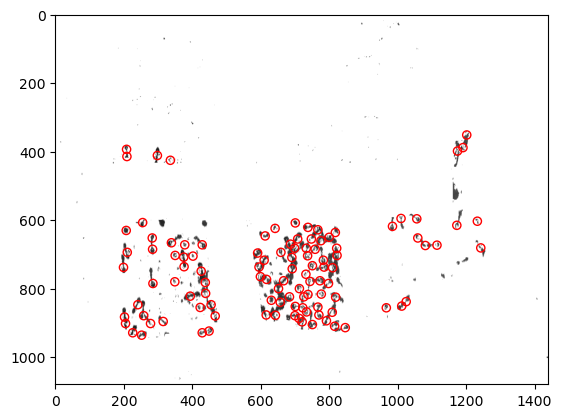

In [62]:
sigma=6
kappa=0.04
thres=0.2
image_rnms = cornerDetector(new, sigma, kappa, thres)

n2=int(np.ceil(3*sigma))
x,y=np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
corners=np.argwhere(image_rnms==1)
plt.imshow(new,cmap='gray')
plt.scatter(corners[:,1],corners[:,0],s=2*n2-1,marker='o',edgecolors='r',facecolors='none')
plt.show()

In [118]:
lines=[]
for tuple1 in corners:
    for tuple2 in corners:
        mean=np.mean([tuple1,tuple2],axis=0)
        if (tuple1[1]!=tuple2[1] or tuple1[0]!=tuple2[0] )and np.linalg.norm(tuple1-tuple2)<50 and np.linalg.norm(tuple1-tuple2)>30 and new[int(mean[0]),int(mean[1])]<100:
            lines.append([tuple1,tuple2])
lines=np.array(lines)

In [117]:
corners[3],corners[4]

(array([ 398, 1175]), array([411, 298]))

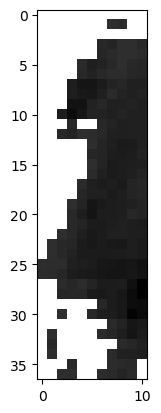

In [115]:
plt.imshow(new[corners[0][0]:corners[1][0],corners[1][1]:corners[0][1]],cmap='gray')

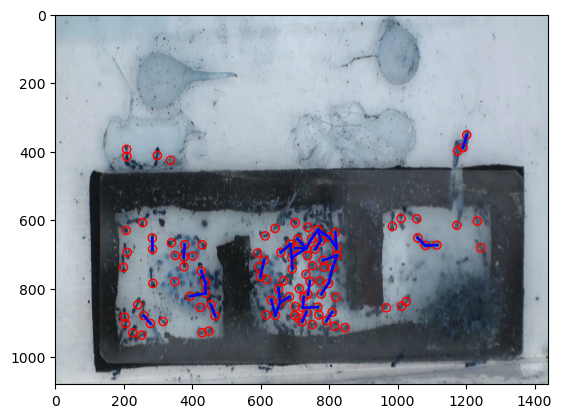

In [120]:
for line in lines:
    plt.plot([line[0][1],line[1][1]],[line[0][0],line[1][0]],c='b')
plt.imshow(data_matrix[0],cmap='gray')
plt.scatter(corners[:,1],corners[:,0],s=2*n2-1,marker='o',edgecolors='r',facecolors='none')
plt.show()

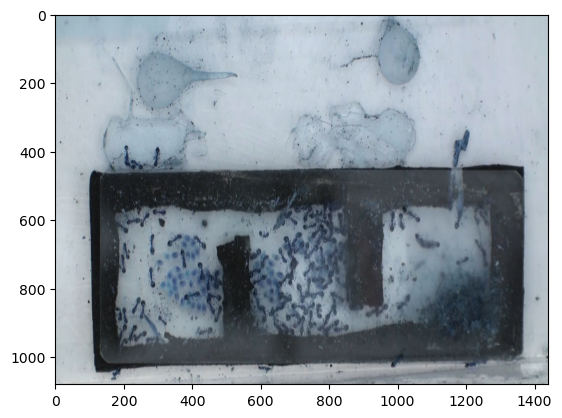

In [18]:
plt.imshow(data_matrix[0],cmap='gray')